# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [3]:
import os
os.chdir(os.getcwd())

In [4]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [5]:
# Define the directories that contain the files downloaded
dir_cs = "2003_download/" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "clean_data.pickle" # path to save cleaned data

In [6]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries','last_pymnt_d']
 # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt','funded_amnt','annual_inc','dti','delinq_2yrs','open_acc','pub_rec','fico_range_high','fico_range_low','revol_bal','total_pymnt','recoveries']
cat_cols = ['term','grade','emp_length','home_ownership','verification_status','loan_status','purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [7]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [8]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"

    
    all_files = os.listdir(directory) # get list of all files from the directory
    all_files.remove('.DS_Store')
    print(all_files)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', skiprows=1)  # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(lambda x: not is_integer(x))  # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows]  # remove invalid rows
    
    return output # return dictionary of dataframe

In [9]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

['LoanStats_securev1_2019Q4.csv.zip', 'LoanStats_securev1_2016Q3.csv.zip', 'LoanStats_securev1_2016Q2.csv.zip', 'LoanStats3a_securev1.csv.zip', 'LoanStats_securev1_2017Q1.csv.zip', 'LoanStats3d_securev1.csv.zip', 'LoanStats_securev1_2017Q3.csv.zip', 'LoanStats_securev1_2018Q4.csv.zip', 'LoanStats_securev1_2017Q2.csv.zip', 'LoanStats_securev1_2016Q1.csv.zip', 'LoanStats_securev1_2016Q4.csv.zip', 'LoanStats_securev1_2019Q3.csv.zip', 'LoanStats_securev1_2018Q1.csv.zip', 'LoanStats3c_securev1.csv.zip', 'LoanStats_securev1_2019Q2.csv.zip', 'LoanStats_securev1_2018Q3.csv.zip', 'LoanStats_securev1_2017Q4.csv.zip', 'LoanStats_securev1_2019Q1.csv.zip', 'LoanStats3b_securev1.csv.zip', 'LoanStats_securev1_2018Q2.csv.zip']
Directory 2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2

### Combine the files

In [10]:
data_cs = pd.concat(files_cs.values()).reset_index(drop=True) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

## Prepare Final Dataset

In [11]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [12]:
del(data_cs)

In [13]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [14]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

In [15]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc)  # apply clean_perc to percentage columns

In [16]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

In [17]:
for i in cat_cols:
     final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x)# for categorical features if the value is null/empty set it to None

## Calculate returns for each loan

In [18]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [19]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data["loan_length"]!=0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 12361 rows


### M1-Pessimistic Method

In [20]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months
final_data['ret_PESS'] = ((final_data["total_pymnt"] - final_data["funded_amnt"])*12)/(final_data["funded_amnt"]*final_data["term_num"])

### M2-Optimistic Method

In [21]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data["total_pymnt"] - final_data["funded_amnt"])*12)/(final_data["funded_amnt"]*final_data["loan_length"])

final_data.loc[final_data.ret_OPT < 0, 'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0, 'ret_PESS']


### Method 3

In [22]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data["loan_length"]

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-(1+i)**final_data["loan_length"])/(1-(1+i))) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (1+i)**remaining_months)- final_data["funded_amnt"]

    # Find the percentage return
    ret_val = (12/T) * final_return / final_data["funded_amnt"]
    return ret_val

In [23]:
final_data['ret_INTa'] = ret_method_3(60,0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60,0.04) # call ret_method_3 with T=60, i=0.04

### Visualize the variables

In [24]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:



        plt.figure(figsize=(6, 4))
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data.sort_values(by=i, ascending=False).head(3)[i].tolist() # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(-0.3,highest_vals[0], highest_vals[0])
        plt.text(0,highest_vals[1], highest_vals[1])
        plt.text(0.3,highest_vals[2], highest_vals[2])
        plt.text(0.1,smallest_val, smallest_val)
        plt.xlabel(i)

        plt.show()

In [25]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    pd.set_option("display.max_rows", 1000) 
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(final_data[i].nunique()) # print number of distinct values
        print(final_data[i].value_counts())
        print("")
        print("")

In [26]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

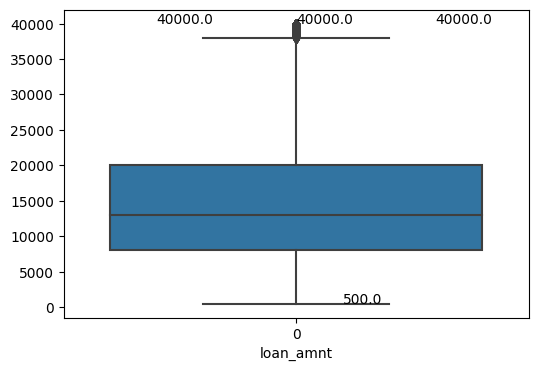

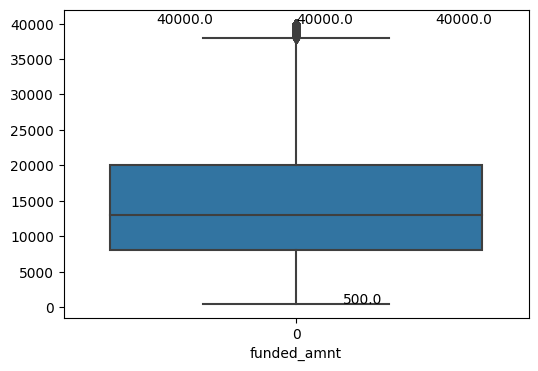

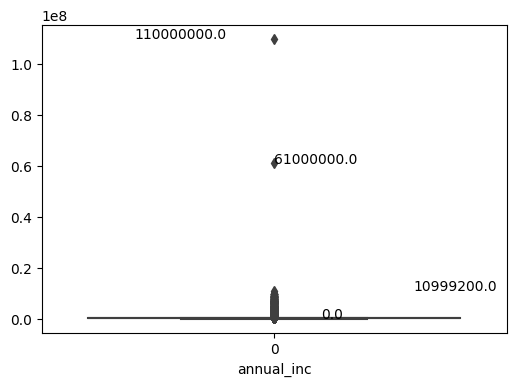

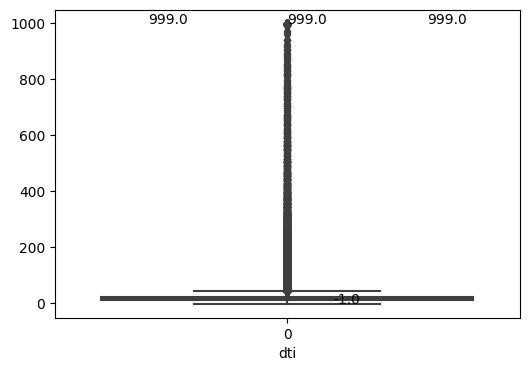

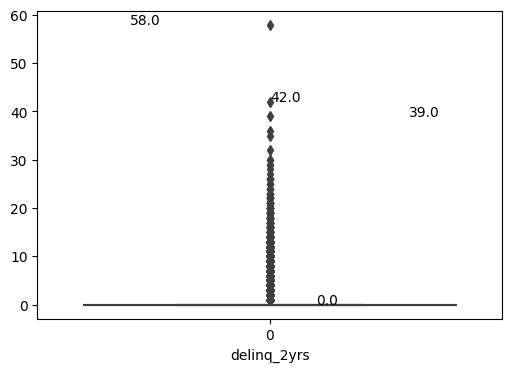

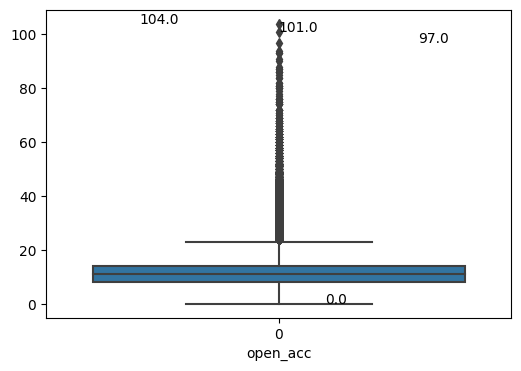

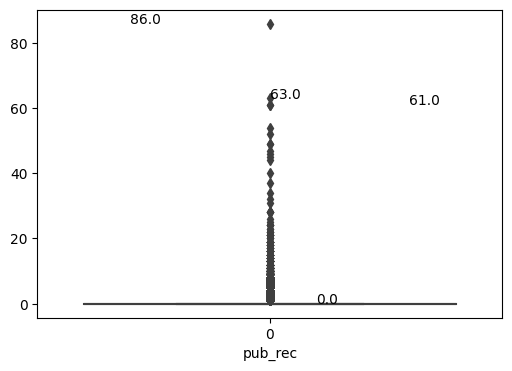

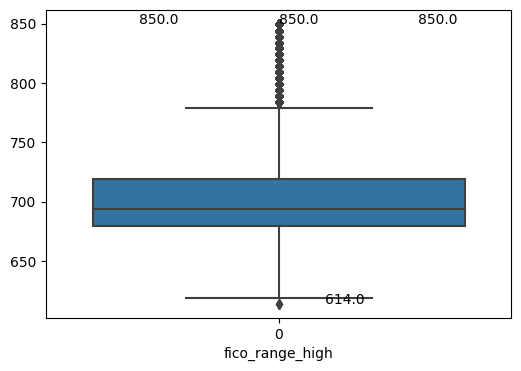

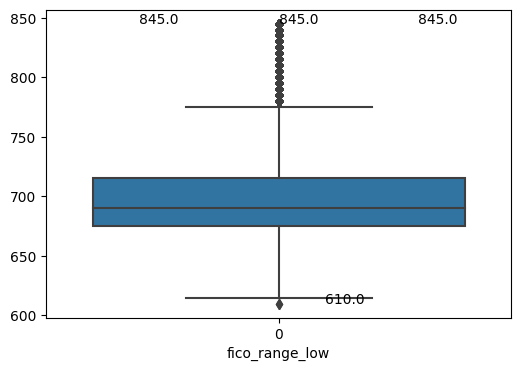

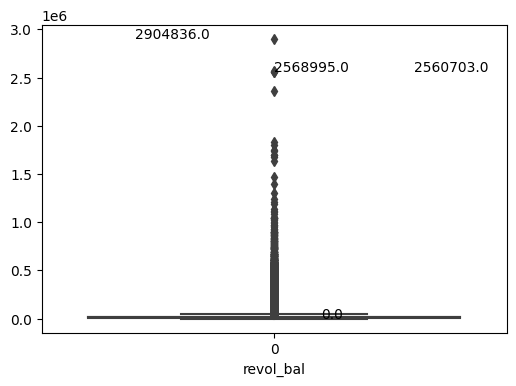

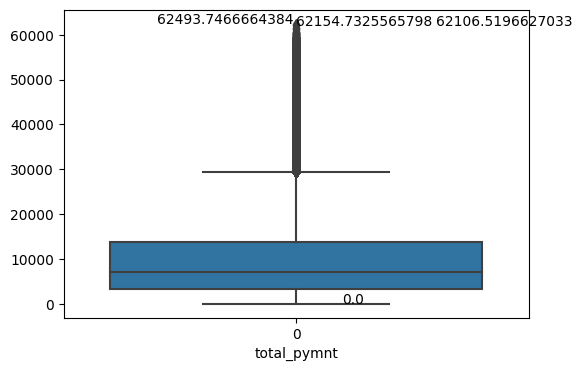

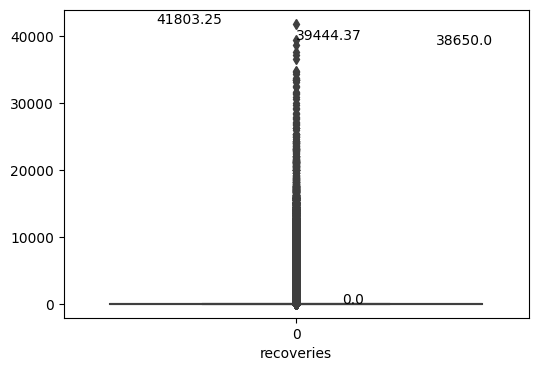

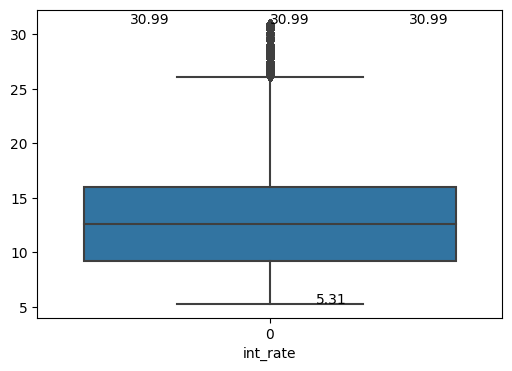

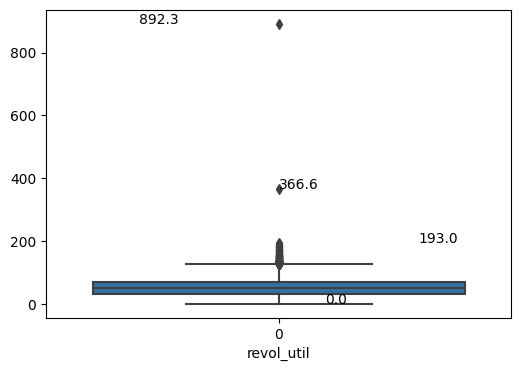

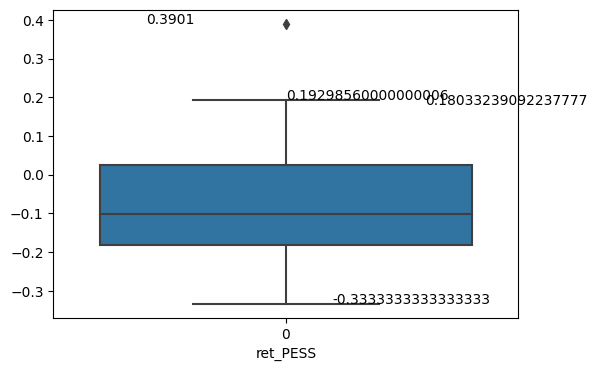

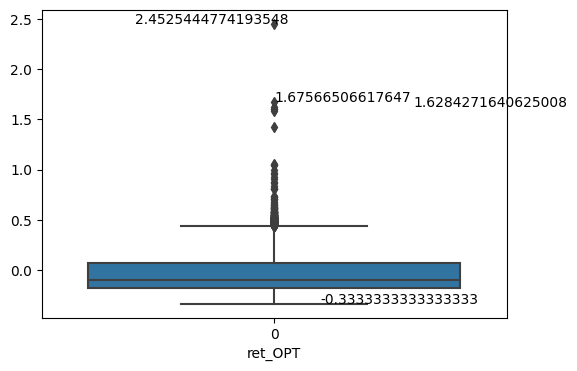

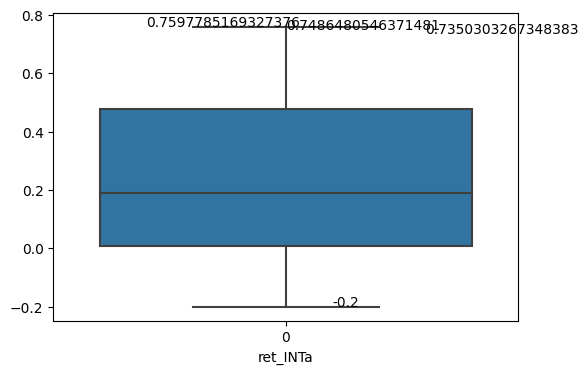

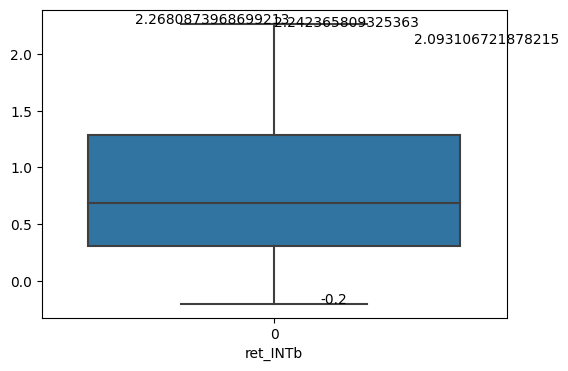

term
2
 36 months    1949756
 60 months     815659
Name: term, dtype: int64


grade
7
B    811304
C    768632
A    596277
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


emp_length
11
10+ years    898370
< 1 year     253650
2 years      247379
3 years      219762
1 year       183001
5 years      171829
4 years      166566
6 years      123700
7 years      110120
8 years      107507
9 years       91449
Name: emp_length, dtype: int64


home_ownership
6
MORTGAGE    1359007
RENT        1090600
OWN          312178
ANY            3393
OTHER           182
NONE             55
Name: home_ownership, dtype: int64


verification_status
3
Source Verified    1066701
Not Verified        997623
Verified            701091
Name: verification_status, dtype: int64


loan_status
9
Current                                                1559756
Fully Paid                                              901142
Charged Off                                             238095
Late (31-120 

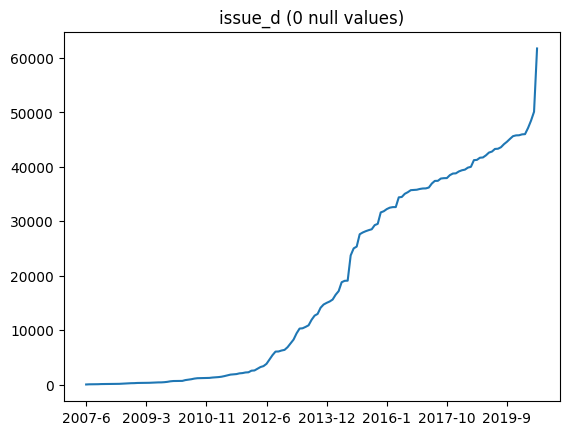

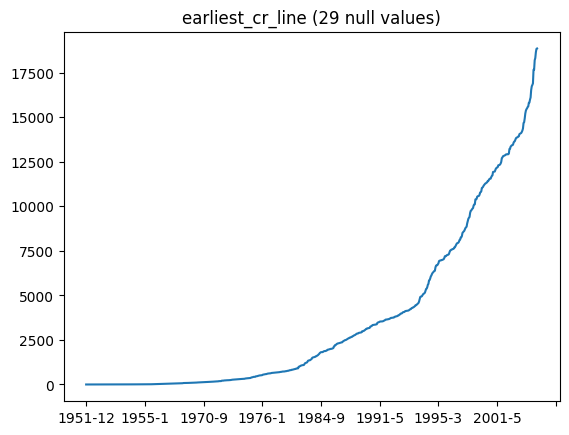

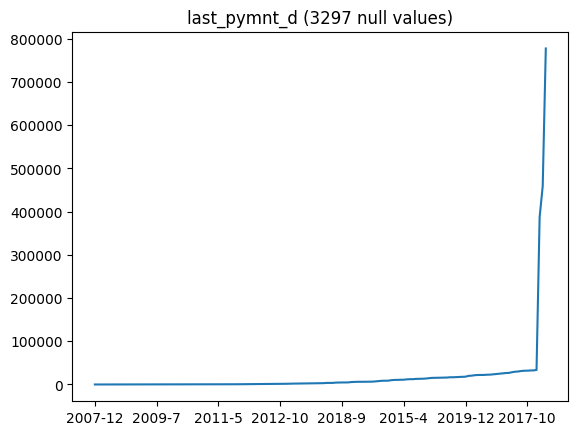

In [27]:
# visualize continuous features/
visualize_float_columns()

visualize_cat_columns()

visualize_date_columns()


### Handle outliers

In [28]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

top_k=['annual_inc','dti','revol_bal','revol_util']

for k in top_k:
        q_25= final_data[k].quantile(0.25)
        q_75= final_data[k].quantile(0.75)
        iqr=q_75-q_25
        lower_cutoff = q_25 - 1.5 * iqr
        upper_cutoff = q_75 + 1.5 * iqr
        final_data = final_data[(final_data[k] >= lower_cutoff) & (final_data[k] <= upper_cutoff)]


# For these features remove the highest 3 points
final_data = final_data[~final_data['delinq_2yrs'].isin(final_data['delinq_2yrs'].nlargest(3))] 
final_data = final_data[~final_data['pub_rec'].isin(final_data['pub_rec'].nlargest(3))]  
final_data = final_data[~final_data['recoveries'].isin(final_data['recoveries'].nlargest(3))] 



print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 318556 rows


In [29]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[~(final_data["loan_status"]=="Current")]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1355298 rows


In [30]:
# Only include loans isssued since 2010
n_rows = len(final_data)

date_min = datetime.date(2010, 1, 1)

final_data = final_data[final_data["issue_d"] >= date_min]


print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7348 rows


### Drop null values

In [31]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data = final_data.dropna(subset=list(required_cols))

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 2837 rows


In [32]:
final_data.reset_index(drop=True,inplace=True)

### Visualize clean data

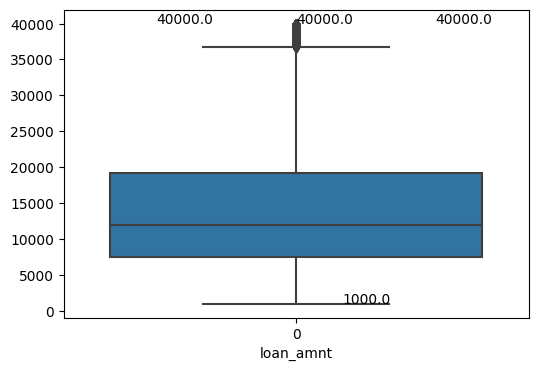

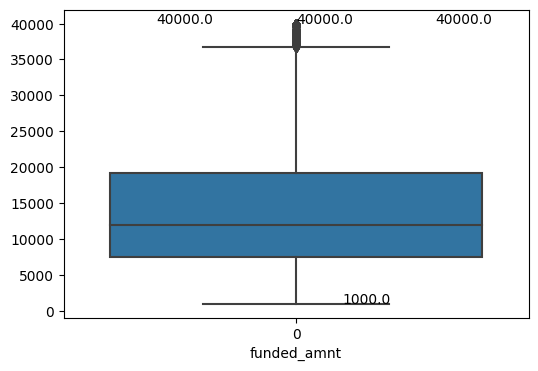

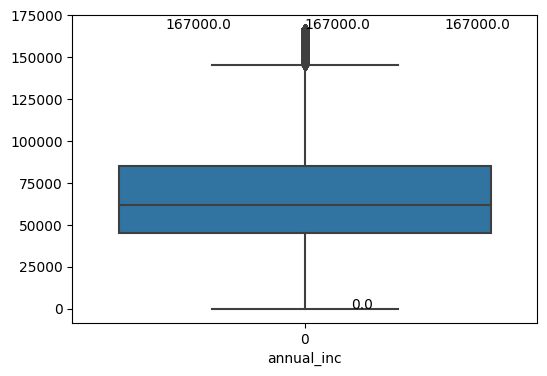

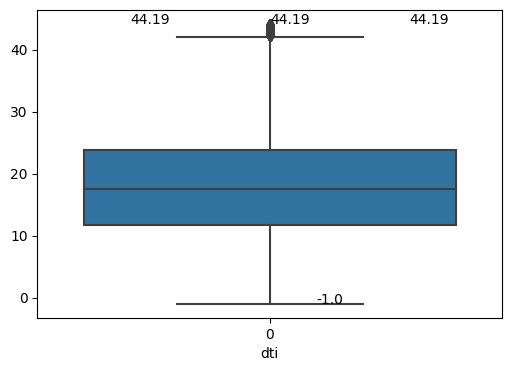

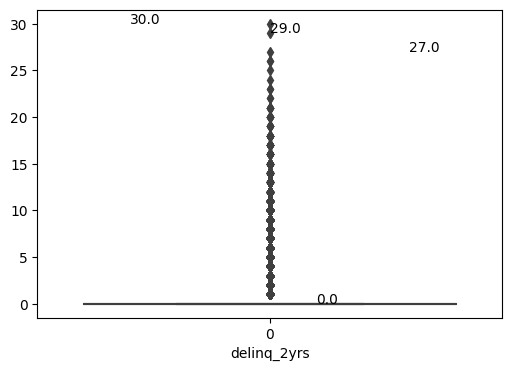

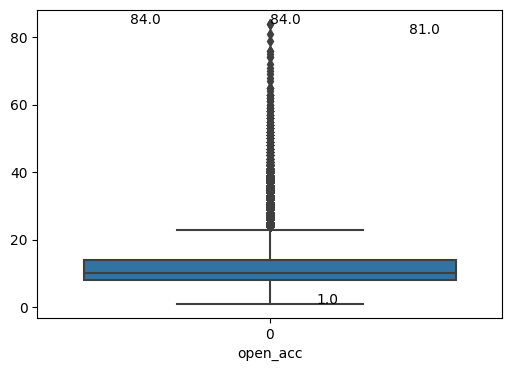

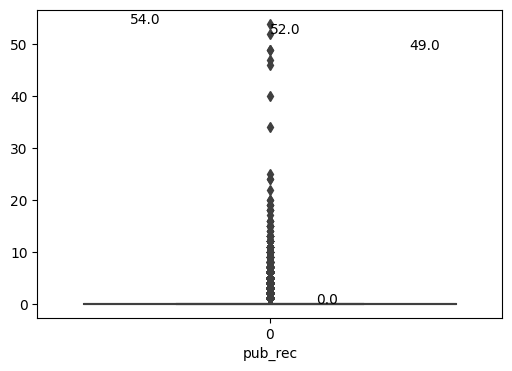

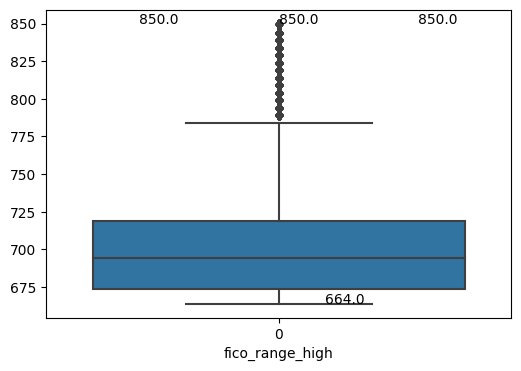

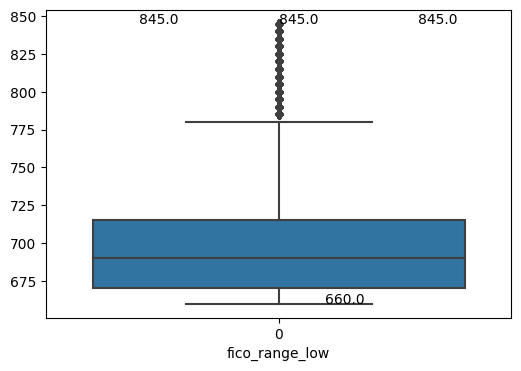

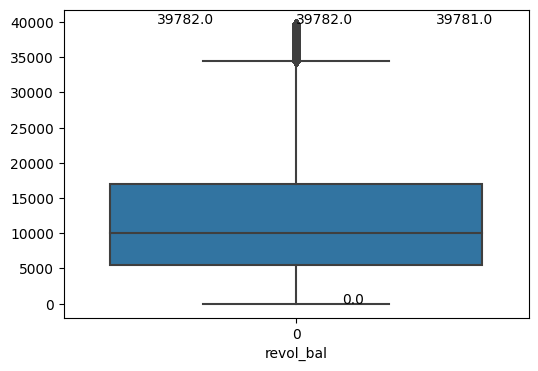

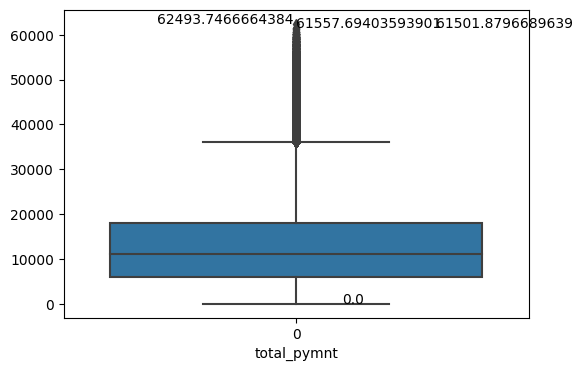

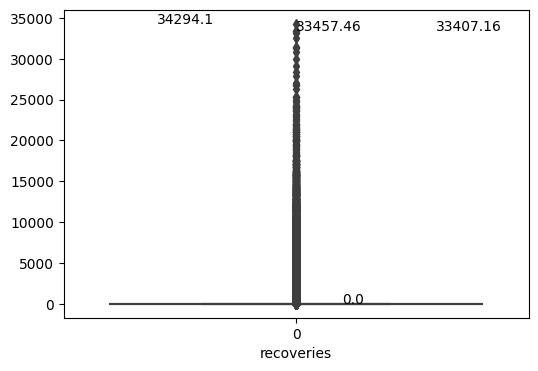

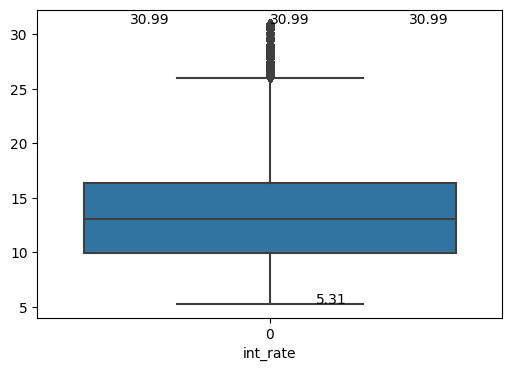

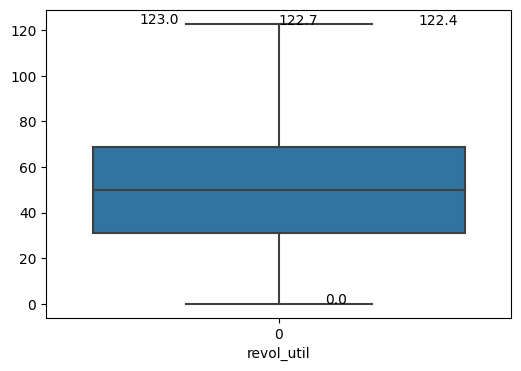

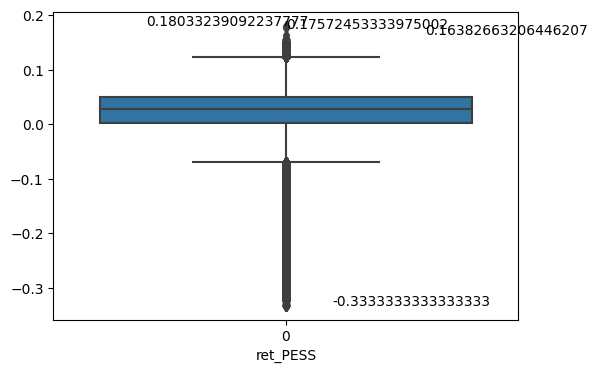

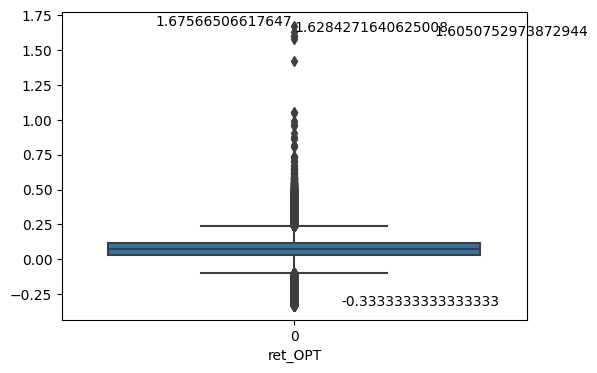

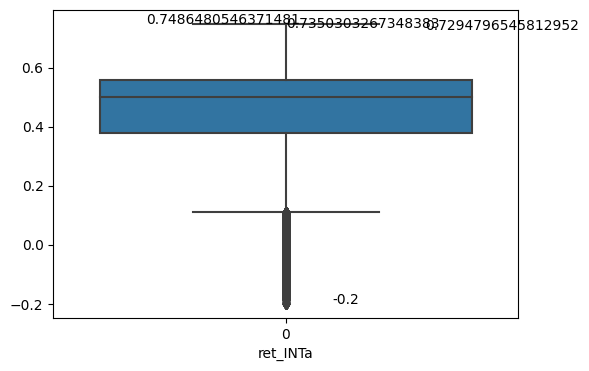

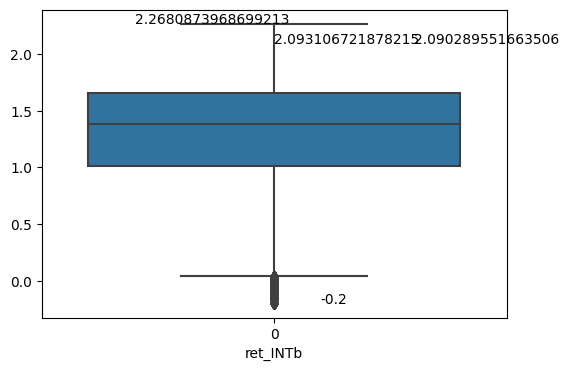

term
2
 36 months    815040
 60 months    266336
Name: term, dtype: int64


grade
7
B    306870
C    303965
A    186146
D    174778
E     76823
F     25894
G      6900
Name: grade, dtype: int64


emp_length
11
10+ years    341699
2 years       99054
< 1 year      88659
3 years       87935
1 year        72669
5 years       69338
4 years       66288
6 years       52085
7 years       48807
8 years       47987
9 years       39108
Name: emp_length, dtype: int64


home_ownership
6
MORTGAGE    514503
RENT        450474
OWN         115623
ANY            688
OTHER           47
NONE            41
Name: home_ownership, dtype: int64


verification_status
3
Source Verified    403354
Not Verified       359417
Verified           318605
Name: verification_status, dtype: int64


loan_status
8
Fully Paid                                             809344
Charged Off                                            215057
Late (31-120 days)                                      30464
In Grace Period            

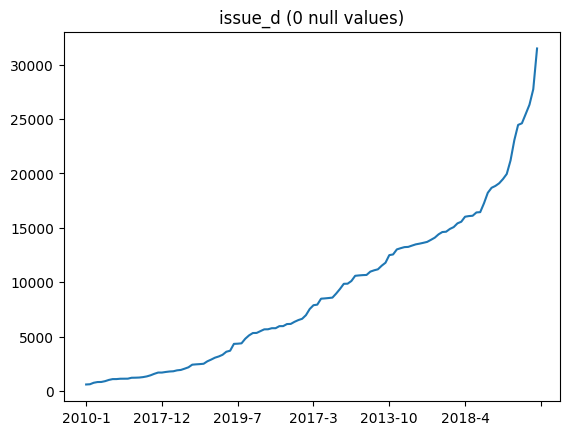

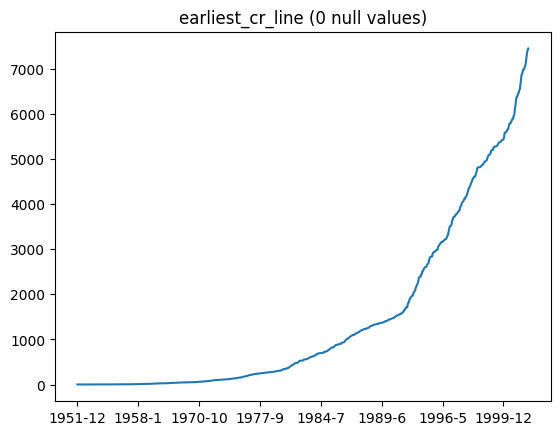

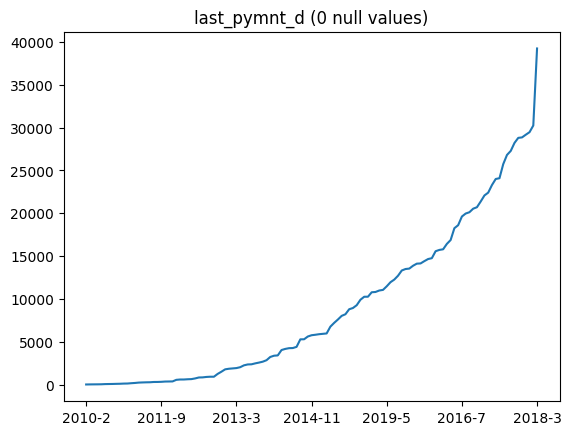

In [33]:
# Visualize the data again after cleaning
visualize_float_columns()


visualize_cat_columns()

visualize_date_columns()

/var/folders/1x/z4spc31954n2gycqnlph1rf40000gn/T/ipykernel_16886/3242286363.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_corr_matrix = final_data.corr()


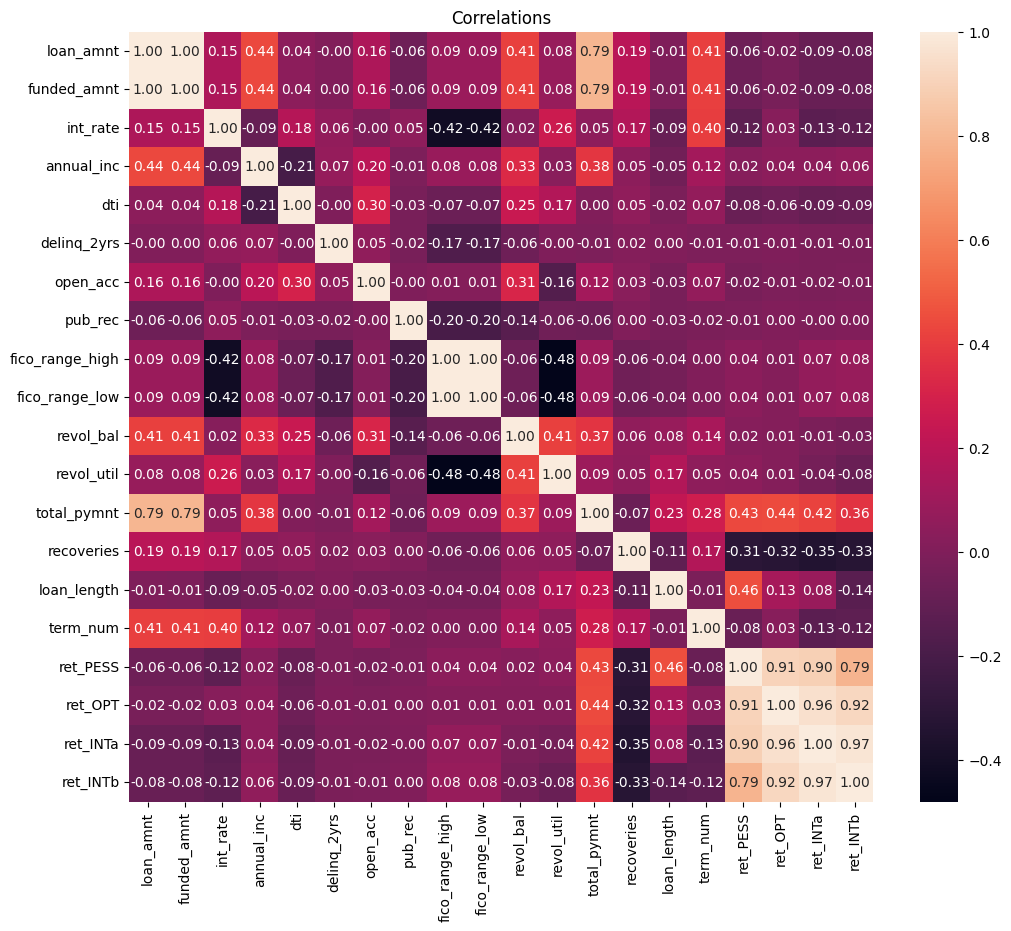

In [34]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
loan_corr_matrix = final_data.corr()
plt.figure(figsize=(12, 10))
seaborn.heatmap(loan_corr_matrix, annot=True,fmt=".2f")
plt.title("Correlations")
plt.show()

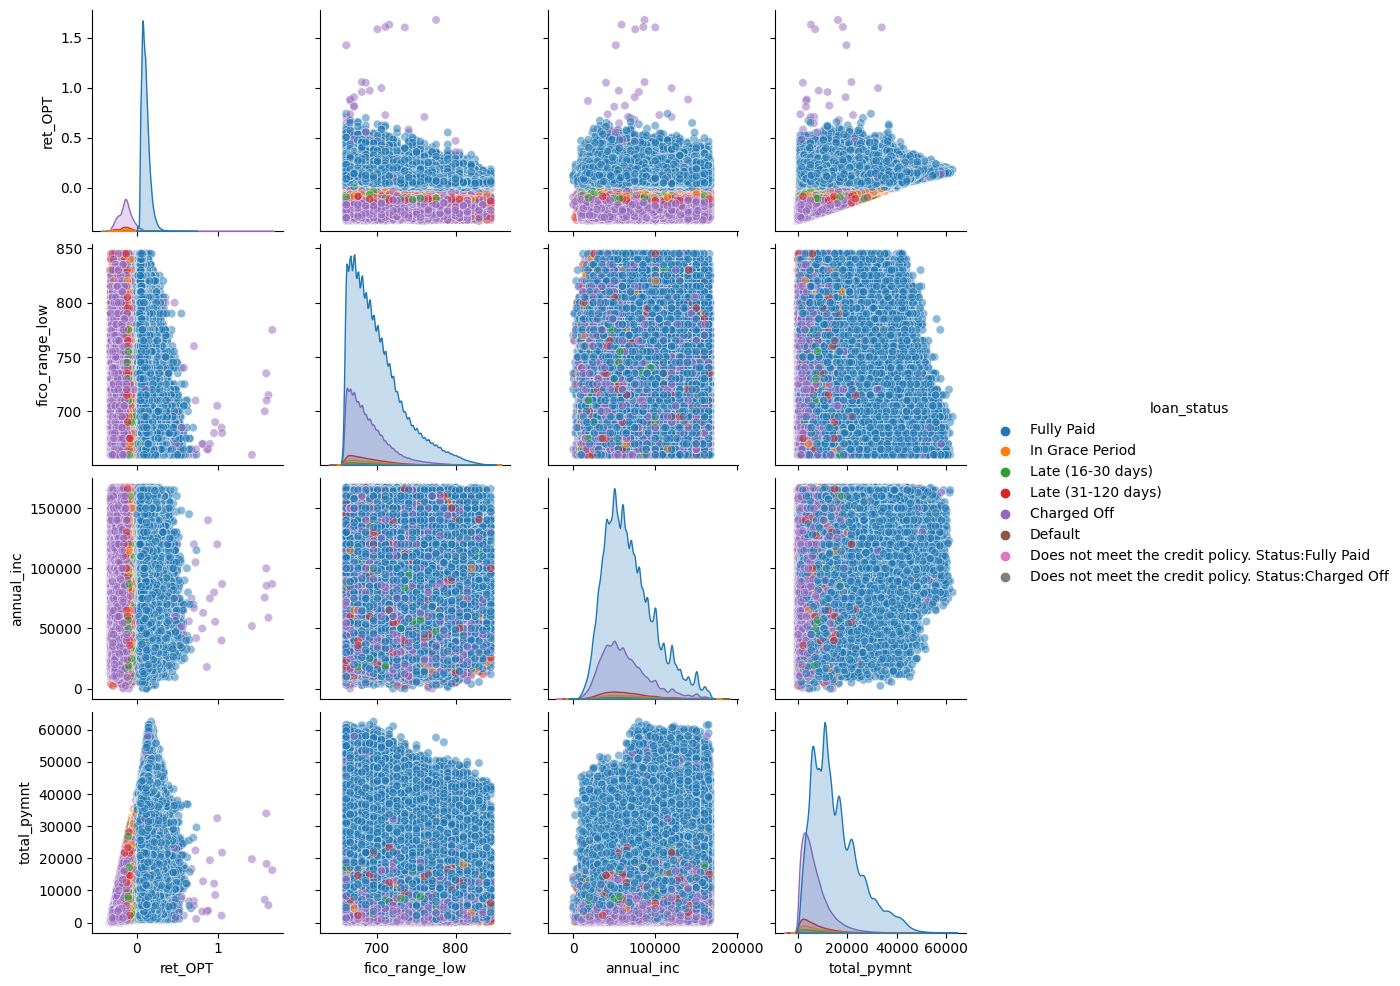

In [35]:
# Visualize relation between loan status and features
 # sns pairplot or scatter plot. Refer to recitations

selected_features = ['loan_status', 'ret_OPT', 'fico_range_low', 'annual_inc', 'total_pymnt']
subset_data = final_data[selected_features]
seaborn.pairplot(subset_data, hue='loan_status', markers='o', plot_kws={'alpha': 0.5})

plt.show()


What do you observe after removing the outliers?

By eliminating the outliers, the skewness in the boxplot substantially decreased, indicating that the skewed data no longer impacts the distribution significantly. Additionally, the average return table demonstrated a favorable trend after the removal of outliers. Consequently, for the loan approval task, it is preferable to exclude any outliers from the final dataset to ensure accurate predictions.


### Data Exploration
Solution to Q.7 from the handout

In [36]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade')['ret_PESS'].mean()*100 # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_OPT'].mean()*100  # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa =  final_data.groupby('grade')['ret_INTa'].mean()*100 # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean()*100 # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean()  # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,17.213809,9.186875,7.234854,0.662181,3.379294,44.544305,131.699863
B,28.377734,17.695767,10.899120,0.359421,4.124568,43.309062,128.102514
C,28.109094,28.262135,14.232296,-0.916578,4.013312,40.963746,123.315127
D,16.162556,36.785522,18.085502,-1.743268,4.181562,38.861506,118.512617
E,7.104189,43.939966,21.324396,-1.970582,4.776856,37.462127,114.691040
F,2.394542,49.718081,24.858979,-2.143638,5.308988,36.166178,111.396408
G,0.638076,55.043478,27.449016,-3.743460,4.573026,33.289497,106.327661


Based on the output of previous cell, write down your answers to Q.7 from the handout.

Q1) What percentage of loans are in each grade?

In the table above, the "perc_of_loans" column displays the proportion of loans in each grade. As expected, a greater proportion of loans are being allocated to higher grade loans.

Q2) What is the default rate in each grade? How do you interpret those numbers?

The above table displays the default rate for each grade in the "perc_default" column. As expected, investments in lower grade categories are high-risk and high-reward, resulting in higher default rates. Conversely, investments in higher grade categories have a very low default rate.

Q3) What is the average interest rate in each grade? How do you interpret these numbers?

The "avg_int_rate" column in the above table represents the average interest rates for each grade. As noted earlier, high-risk and high-reward investments typically carry higher interest rates. Therefore, we observe an increasing trend in the average interest rates as the borrower's grade drops, indicating a higher risk investment.

Q4) What is the average percentage (annual) return per grade (as calculated using the three methods in part 6.)? (Assume two different yearly rates for M 3: (i = 2.3) and (i = 4.0))

The column "return_INTa" displays the average percentage annual return for i = 2.3, while "return_INTb" shows the average percentage return for i = 4. As the borrower's grade drops, the average return rate per grade continues to decrease. This is due to the high default rate, even when the borrower's interest rate is high. Consequently, lower grade borrowers pose a higher investment risk, resulting in lower returns.

Q5) Do these numbers surprise you? If you had to invest in one grade only, which loans would you invest in?

It is not surprising that higher grade borrowers offer greater returns compared to lower grade borrowers. As a result, investments in higher grade borrowers are generally considered safer and are classified as good investments. For this reason, investing in grade A borrowers would be a wise choice as it offers a combination of safety and good returns.


### Save a Pickle

In [37]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
feature_remove=['total_pymnt','recoveries']
continuous_features = [feature for feature in continuous_features if feature not in feature_remove]

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

We are excluding the total_pymt and recoveries variables from the dataset for the prediction task because they represent historical payment information for a funded loan. As we would not have access to this information when predicting future loans, it is essential to remove these variables during the model training process as it's irrlevant at the time of decision making.

In [38]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )